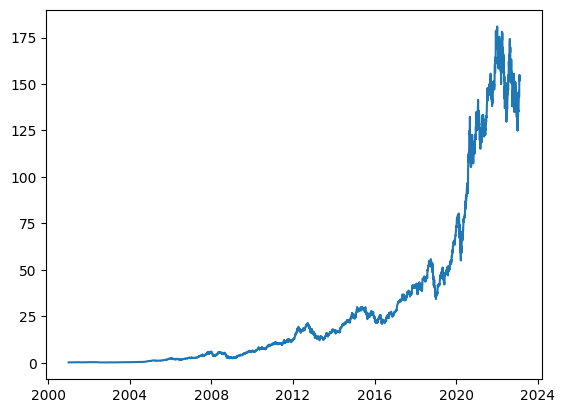

In [20]:
import yfinance
from matplotlib import pyplot as plt

stock_abbr = 'AAPL'
start, end = '2000-12-31', '2023-12-31'

stock_ticker = yfinance.Ticker(stock_abbr)
stock = stock_ticker.history(start=start, end=end)

plt.plot(stock['Close'])
plt.show()


In [21]:
stock['High_t-1'] = stock.High.shift(1)
stock['Low_t-1'] = stock.Low.shift(1)
stock = stock.tail(-1)

stock['is_gap'] = [stock['High_t-1'][i] < stock['Low'][i] or stock['Low_t-1'][i] > stock['High'][i] for i in range(len(stock))]
stock['is_gap_up'] = [stock['High_t-1'][i] < stock['Low'][i] for i in range(len(stock))]

stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up
Date,,,,,,,,,,,
2001-01-03,0.220716,0.254013,0.219764,0.249256,817073600,0.0,0.0,0.232131,0.221667,False,False
2001-01-04,0.276132,0.281602,0.255915,0.259721,739396000,0.0,0.0,0.254013,0.219764,True,True
2001-01-05,0.257818,0.264478,0.244499,0.249256,412356000,0.0,0.0,0.281602,0.255915,False,False
2001-01-08,0.257818,0.258532,0.242596,0.252110,373699200,0.0,0.0,0.264478,0.244499,False,False
2001-01-09,0.255915,0.268521,0.252110,0.261624,588929600,0.0,0.0,0.258532,0.242596,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,143.970001,146.610001,141.320007,145.429993,77663600,0.0,0.0,144.339996,142.279999,False,False
2023-02-02,148.899994,151.179993,148.169998,150.820007,118339000,0.0,0.0,146.610001,141.320007,True,True
2023-02-03,148.029999,157.380005,147.830002,154.500000,154279900,0.0,0.0,151.179993,148.169998,False,False


In [22]:
!node get_earnings.js {stock_abbr}

In [24]:
import json

f = open(f'{stock_abbr}.json')
earnings = json.load(f)
print(earnings)
f.close()

!rm {stock_abbr}.json

[['2024-01-31', None], ['2024-01-31', None], ['2023-10-25', None], ['2023-07-26', None], ['2023-04-26', None], ['2023-02-02', 1.88], ['2022-10-27', 1.29], ['2022-07-28', 1.2], ['2022-04-28', 1.52], ['2022-01-27', 2.1], ['2021-10-28', 1.24], ['2021-07-27', 1.3], ['2021-04-28', 1.4], ['2021-01-27', 1.68], ['2020-10-29', 0.73], ['2020-07-30', 0.65], ['2020-04-30', 0.64], ['2020-01-28', 1.25], ['2019-10-30', 0.76], ['2019-07-30', 0.55], ['2019-04-30', 0.62], ['2019-01-29', 1.05], ['2018-11-01', 0.73], ['2018-07-31', 2.34], ['2018-05-01', 2.73], ['2018-02-01', 3.89], ['2017-11-02', 2.07], ['2017-08-01', 1.67], ['2017-05-02', 2.1], ['2017-01-31', 3.36], ['2016-10-25', 1.67], ['2016-07-26', 1.42], ['2016-04-26', 1.9], ['2016-01-26', 3.28], ['2015-10-27', 1.96], ['2015-07-21', 1.85], ['2015-04-27', 2.33], ['2015-01-27', 3.06], ['2014-10-20', 1.42], ['2014-07-22', 1.28], ['2014-04-23', 1.66], ['2014-01-27', 2.07], ['2013-10-28', 1.18], ['2013-07-23', 1.07], ['2013-04-23', 1.44], ['2013-01-23', 